In [8]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

file_path = '/content/sample_data/amazon_reviews.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['reviewText']).reset_index(drop=True)

def map_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

data['sentiment'] = data['overall'].apply(map_sentiment)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

data['cleaned_review'] = data['reviewText'].apply(preprocess_text)

X = data['cleaned_review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')



In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

sentiment_mapping = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
y_train_mapped = y_train.map(sentiment_mapping).values
y_test_mapped = y_test.map(sentiment_mapping).values

model.fit(X_train_padded, y_train_mapped, validation_data=(X_test_padded, y_test_mapped), epochs=5, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 420ms/step - accuracy: 0.7249 - loss: 0.8494 - val_accuracy: 0.7700 - val_loss: 0.7039
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.7727 - loss: 0.6995 - val_accuracy: 0.7700 - val_loss: 0.6903
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 0.7739 - loss: 0.6886 - val_accuracy: 0.7700 - val_loss: 0.6776
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 332ms/step - accuracy: 0.7638 - loss: 0.7069 - val_accuracy: 0.7700 - val_loss: 0.6777
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.7856 - loss: 0.6539 - val_accuracy: 0.7300 - val_loss: 0.7165


In [11]:

loss, accuracy = model.evaluate(X_test_padded, y_test_mapped)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7199 - loss: 0.7315
Test Loss: 0.7164788246154785
Test Accuracy: 0.7300000190734863


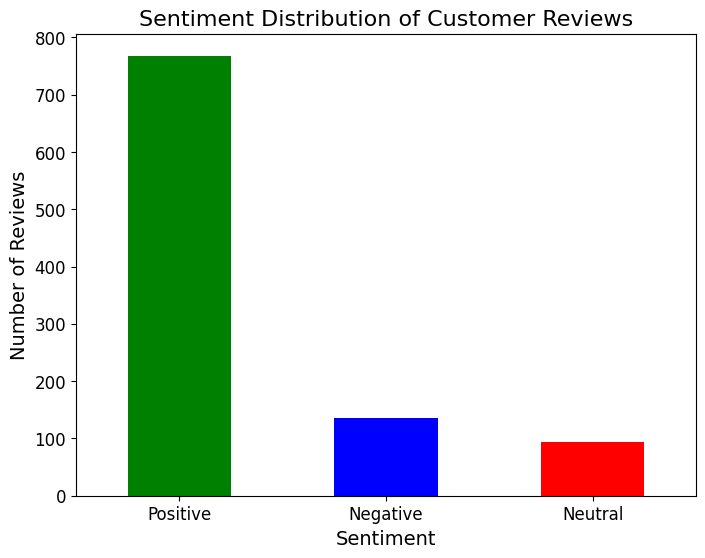

In [13]:
import matplotlib.pyplot as plt

sentiment_counts = data['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title("Sentiment Distribution of Customer Reviews", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()
